In [1]:
%matplotlib inline

import cv2, matplotlib
import numpy as np
from skimage.morphology import (
    skeletonize,
    skeletonize_3d,
    medial_axis,
    thin,
    local_minima,
    local_maxima,
)
from skimage.transform import rescale, resize, downscale_local_mean
from scipy.ndimage import distance_transform_edt

from math import sqrt

import matplotlib.pyplot as plt

from os.path import expanduser, splitext
from os import scandir, makedirs

# import random

import csv

from tqdm import tnrange, tqdm_notebook

from pathlib import Path

debug = False  # plot every steps

In [ ]:
from floorplan_analysis import read_bgr_from_image_unicode, get_unit_mask
from floorplan_analysis import align_fp, rescale_fp
from floorplan_analysis import mono_fp
from floorplan_analysis import read_mono_from_image_unicode, save_mono_to_image_unicode
from floorplan_analysis import fp_float_from_mono, fp_uint8_from_mono

# postprocess files

In [11]:
def process_floorplan_mono(
    path_from, area, filename_to, dir_to="/data/fp_img_processed/", ext_to=".png"
):
    try:
        bgr = read_bgr_from_image_unicode(path_from)
        unit_comb = get_unit_mask(bgr)
        unit_comb = rescale_fp(unit_comb, area)
        unit_comb = align_fp(unit_comb)

        mono = mono_fp(unit_comb)
        save_mono_to_image_unicode(mono, dir_to + filename_to + ext_to, ext_to)
    except:
        pass

In [14]:
def realign_on_mono(
    path_from, area, filename_to, dir_to="/data/fp_img_processed/", ext_to=".png"
):
    try:
        mono = read_mono_from_image_unicode(path_from)
        unit_comb = fp_uint8_from_mono(mono)
        
        unit_comb = align_fp(unit_comb)
        
        mono = mono_fp(unit_comb)
        save_mono_to_image_unicode(mono, dir_to + filename_to + ext_to, ext_to)
    except:
        pass

In [15]:
realign_on_mono("/data/fp_img_processed/8516_87.png", 85, "mono", dir_to="")

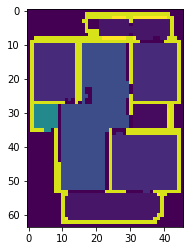

In [16]:
plt.imshow(read_mono_from_image_unicode("mono.png"))

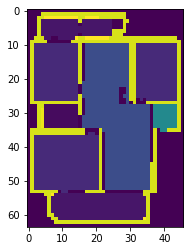

In [17]:
mono = read_mono_from_image_unicode("/data/fp_img_processed/8516_87.png")
plt.imshow(mono)

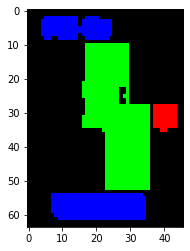

In [18]:
unit_comb = fp_uint8_from_mono(mono)
plt.imshow(unit_comb[:, :, [1, 2, 4]])

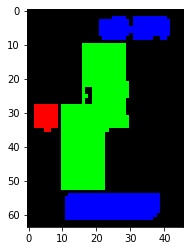

In [19]:
unit_comb = align_fp(unit_comb)
plt.imshow(unit_comb[:, :, [1, 2, 4]])

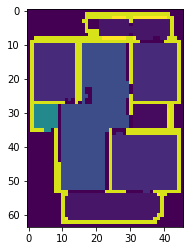

In [20]:
mono = mono_fp(unit_comb)
plt.imshow(mono)

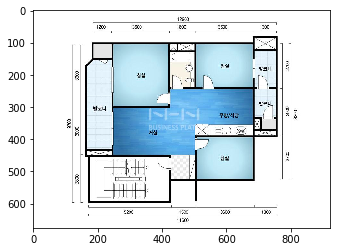

In [21]:
bgr = read_bgr_from_image_unicode("/fp_img/8516_87.jpg")
plt.imshow(bgr)

In [22]:
unit_comb = get_unit_mask(bgr)

In [23]:
unit_comb = rescale_fp(unit_comb, 85)

In [24]:
unit_comb = align_fp(unit_comb)

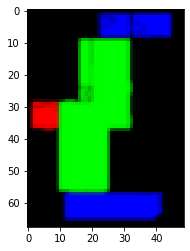

In [25]:
plt.imshow(unit_comb[:, :, [1, 2, 4]])

In [26]:
mono = mono_fp(unit_comb)

# main

In [39]:
dir_ID_from = "/data/fp_img_processed/"
dir_IDs_exclude = "/data/exclude/"

dir_from = "/data/fp_img_processed/"

dir_to = "/data/fp_img_processed/"
makedirs(dir_to, exist_ok=True)

ext_to = ".png"

### all of the plans
ID_ext_dict = {
    splitext(f.name)[0]: splitext(f.name)[1]
    for f in scandir(dir_ID_from)
    if f.is_file()
}
print(len(ID_ext_dict.keys()), "floorplans")

50412 floorplans


In [40]:
list(ID_ext_dict.items())[:10]

[('3803_145', '.png'),
 ('112076_61B1d', '.png'),
 ('1200_85A', '.png'),
 ('2604_104(동신)', '.png'),
 ('3039_154B', '.png'),
 ('100273_82', '.png'),
 ('9155_149', '.png'),
 ('19690_192', '.png'),
 ('1912_71', '.png'),
 ('105094_150', '.png')]

In [41]:
files_IDs_exclude = list(Path(expanduser(dir_IDs_exclude)).glob("*.csv"))
print(files_IDs_exclude)

[PosixPath('/data/exclude/fp_img_multi-level.csv'), PosixPath('/data/exclude/fp_img_multi-unit.csv'), PosixPath('/data/exclude/fp_img_exclude.csv')]


In [42]:
IDs_excl = set()
for file_excl in files_IDs_exclude:
    _, file_excl_list = read_from_csv(str(file_excl))
    if file_excl_list:
        list_excl = [row[0] for row in file_excl_list]
    IDs_excl |= set(list_excl)
    print(file_excl, "processed:", len(list_excl), "floorplans to exclude")

# _, fp_img_processed_list = read_from_csv(exp_path_fp_img)
# if fp_img_processed_list:
#     list_excl = [row[0] for row in fp_img_processed_list]
#     IDs_excl |= set(list_excl)
#     print(len(list_excl), "floorplans already processed")

/data/exclude/fp_img_multi-level.csv processed: 861 floorplans to exclude
/data/exclude/fp_img_multi-unit.csv processed: 15 floorplans to exclude
/data/exclude/fp_img_exclude.csv processed: 861 floorplans to exclude


In [43]:
import pandas as pd

path_csv = "/data/fp_refined.csv"

df = pd.read_csv(path_csv)
df = df.set_index("id_after")
df

,Path,index,APT_ID,Date,year,norm_year,yyyymm,N_Housings,Max_Floors,Min_Floors,...,sido_cluster_code,sido_sgg_name,FP_ID,Area,norm_log_area,area_85,Entrance,Rooms,Baths,N_Units
id_after,,,,,,,,,,,,,,,,,,,,,
8928_160,/data/fp_img_processed/8928_160.png,1,8928,2004-06-01T00:00:00Z,2004,0.70,200406,212,22,20,...,0,서울시 강남구,160,134.30,1.313282,False,계단식,4,2,84
8928_183,/data/fp_img_processed/8928_183.png,2,8928,2004-06-01T00:00:00Z,2004,0.70,200406,212,22,20,...,0,서울시 강남구,183,153.80,1.702528,False,계단식,4,2,44
8928_201A,/data/fp_img_processed/8928_201A.png,3,8928,2004-06-01T00:00:00Z,2004,0.70,200406,212,22,20,...,0,서울시 강남구,201A,170.32,1.995448,False,계단식,4,2,42
8928_204B,/data/fp_img_processed/8928_204B.png,4,8928,2004-06-01T00:00:00Z,2004,0.70,200406,212,22,20,...,0,서울시 강남구,204B,168.42,1.963240,False,계단식,4,2,42
960_35,/data/fp_img_processed/960_35.png,5,960,1982-11-01T00:00:00Z,1982,0.26,198211,5040,5,5,...,0,서울시 강남구,35,35.64,-2.495452,False,계단식,2,1,530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115454_21D,/data/fp_img_processed/115454_21D.png,50577,115454,2017-03-01T00:00:00Z,2017,0.96,201703,72,4,4,...,8,제주도 제주시,21D,14.50,-5.077429,False,계단식,2,1,20
115454_34E,/data/fp_img_processed/115454_34E.png,50578,115454,2017-03-01T00:00:00Z,2017,0.96,201703,72,4,4,...,8,제주도 제주시,34E,21.57,-3.937185,False,계단식,2,1,4
115454_36B,/data/fp_img_processed/115454_36B.png,50579,115454,2017-03-01T00:00:00Z,2017,0.96,201703,72,4,4,...,8,제주도 제주시,36B,24.86,-3.529623,False,계단식,3,2,16


In [44]:
ID_set = set(ID_ext_dict.keys()).difference(IDs_excl)
ID_set = ID_set.intersection(df.index)
IDs = list(ID_set)
print(len(IDs), "floorplans to go")

50412 floorplans to go


In [45]:
paths_from = [dir_from + ID + ID_ext_dict[ID] for ID in IDs]
print(paths_from[:10])

['/data/fp_img_processed/25561_104.png', '/data/fp_img_processed/108245_111D.png', '/data/fp_img_processed/1382_80.png', '/data/fp_img_processed/23768_194B.png', '/data/fp_img_processed/107683_127F3.png', '/data/fp_img_processed/104507_20E.png', '/data/fp_img_processed/11977_81B.png', '/data/fp_img_processed/27501_112E.png', '/data/fp_img_processed/15522_54S.png', '/data/fp_img_processed/22971_213.png']


In [46]:
df.Area

id_after
8928_160      134.30
8928_183      153.80
8928_201A     170.32
8928_204B     168.42
960_35         35.64
               ...  
115454_21D     14.50
115454_34E     21.57
115454_36B     24.86
115454_37A     25.67
115454_38C     25.21
Name: Area, Length: 50540, dtype: float64

In [47]:
area_list = [df.Area[ID] for ID in IDs]
area_list[:10]

[84.82, 84.74, 59.98, 159.19, 97.16, 12.03, 59.69, 84.42, 39.38, 177.77]

# re-do the align

In [48]:
from multiprocessing import Pool

makedirs(dir_to, exist_ok=True)

with Pool(7) as p:
    p.starmap(realign_on_mono, zip(paths_from, area_list, IDs))

    ls /data/fp_img_processed/ | wc -l

In [49]:
!ls /data/fp_img_processed/8516_87* -al

-rw-r--r-- 1 root root 652 May  6 11:04 /data/fp_img_processed/8516_87.png
